In [1]:
    # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, bias=True, relu=True):
        super(ConvBlock, self).__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias),
            nn.BatchNorm2d(out_channels)
        ]
        if relu:
            layers.append(nn.ReLU())
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.layers(x)
        return out
    
    

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, kernel_size=1, stride=1)
        self.conv2 = ConvBlock(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.conv3 = ConvBlock(out_channels, out_channels*self.expansion, kernel_size=1, stride=1, padding=0, relu=False)
        
        self.i_downsample = i_downsample
        self.stride = stride
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        if self.i_downsample:
            x = self.i_downsample(x)
        out = self.relu(out+x)
        return out

class Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, i_downsample=None, stride=1):
        super(Block, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.conv2 = ConvBlock(out_channels, out_channels*self.expansion, kernel_size=3, padding=1, stride=1, bias=False, relu=False)        
        self.i_downsample = i_downsample
        self.relu = nn.ReLU()
    
    def forward(self, x):
      
        out = self.conv1(x)
        out = self.conv2(out)
        if self.i_downsample:
            x = self.i_downsample(x)
        out = self.relu(out+x)
        return out

class ResNet(nn.Module):
    def __init__(self, ResBlock, in_channels, layer_list, planes, num_classes, num_channels=3, stride=2):
        super(ResNet, self).__init__()
        self.in_channels = in_channels
        self.conv1 = ConvBlock(num_channels, in_channels, kernel_size=7, stride=2, padding=3, bias=False)
#         print(self.conv1)
        self.max_pooling = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        layers = [self._make_layer(ResBlock, layer_list[0], planes[0])]
        for i in range(1, len(layer_list)):
            layers.append(self._make_layer(ResBlock, layer_list[i], planes[i], stride=2))
        self.layers = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(planes[-1]*ResBlock.expansion, num_classes)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.max_pooling(out)
        out = self.layers(out)
        out = out.reshape(out.shape[0], -1)
#         print(out.shape[0])
        out = self.fc(out)
        return out
    
    def _make_layer(self, ResBlock, num_blocks, planes, stride=1):
        ii_downsample = None
        layers = []
        if stride != 1 or self.in_channels != planes * ResBlock.expansion:
            ii_downsample = ConvBlock(self.in_channels, planes * ResBlock.expansion, kernel_size=1, stride=stride, relu=False)
            
        layers.append(ResBlock(self.in_channels, planes, ii_downsample, stride))
        self.in_channels = planes * ResBlock.expansion
        for i in range(num_blocks-1):
            layers.append(ResBlock(self.in_channels, planes))
        return nn.Sequential(*layers)
    
def ResNet18(num_classes, channels=3):
    return ResNet(Block, 64, [2, 2, 2, 2], [64, 128, 256, 512], num_classes, channels, 1)

def ResNet34(num_classes, channels=3):
    return ResNet(Block, 64, [3, 4, 6, 3], [64, 128, 256, 512], num_classes, channels, 1)
    
def ResNet50(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 4, 6, 3], [64, 128, 256, 512], num_classes, channels, 2)

def ResNet101(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 4, 23, 3], [64, 128, 256, 512], num_classes, channels, 2)

def ResNet152(num_classes, channels=3):
    return ResNet(Bottleneck, 64, [3, 8, 36, 3], [64, 128, 256, 512], num_classes, channels, 2)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [5]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

trainloader = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True, num_workers=2)

test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

testloader = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False, num_workers=2)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


100%|██████████| 170498071/170498071 [00:16<00:00, 10133265.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet34(10).to(device)
model.load_state_dict(torch.load("/kaggle/input/resnet-result/resnet34_cifar10_10.pt", weights_only=True))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.1, patience=5)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score


def evaluate(model, plot=False):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    cm = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    print("Accuracy: ", accuracy)
    print("F1 score: ", f1_macro)
    if plot:
        class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

epochs = 100
for epoch in range(epochs):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
#         print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if (epoch+1)%(epochs//10) == 0:
        print(f'Loss [{epoch}](epoch): ', running_loss / len(trainloader))
        running_loss = 0.0
        evaluate(model)
        cur_id = (epoch+1)//(epochs//10)
        torch.save(model.state_dict(), f"resnet50_cifar10_{cur_id}.pt")

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)
            


Loss [9](epoch):  0.4637472887935541
Accuracy:  0.8099
F1 score:  0.8097463133846308
Loss [19](epoch):  0.3707735541531497
Accuracy:  0.8201
F1 score:  0.8187372799327356
Loss [29](epoch):  0.33722075549385433
Accuracy:  0.8257
F1 score:  0.8249686830110641
Loss [39](epoch):  0.31684012288022834
Accuracy:  0.8266
F1 score:  0.8266891062561396
Loss [49](epoch):  0.29854114147860683
Accuracy:  0.8263
F1 score:  0.8265882204038796
Loss [59](epoch):  0.27955950487910025
Accuracy:  0.8315
F1 score:  0.8306550488406531
Loss [69](epoch):  0.2597813250692299
Accuracy:  0.8268
F1 score:  0.8255949350387463
Loss [79](epoch):  0.2455323825178244
Accuracy:  0.8277
F1 score:  0.8274142920411733
Loss [89](epoch):  0.22707200326654306
Accuracy:  0.8245
F1 score:  0.8252013407923167
Loss [99](epoch):  0.20897295175458463
Accuracy:  0.8243
F1 score:  0.824902258592925


Accuracy:  0.8243
F1 score:  0.824902258592925


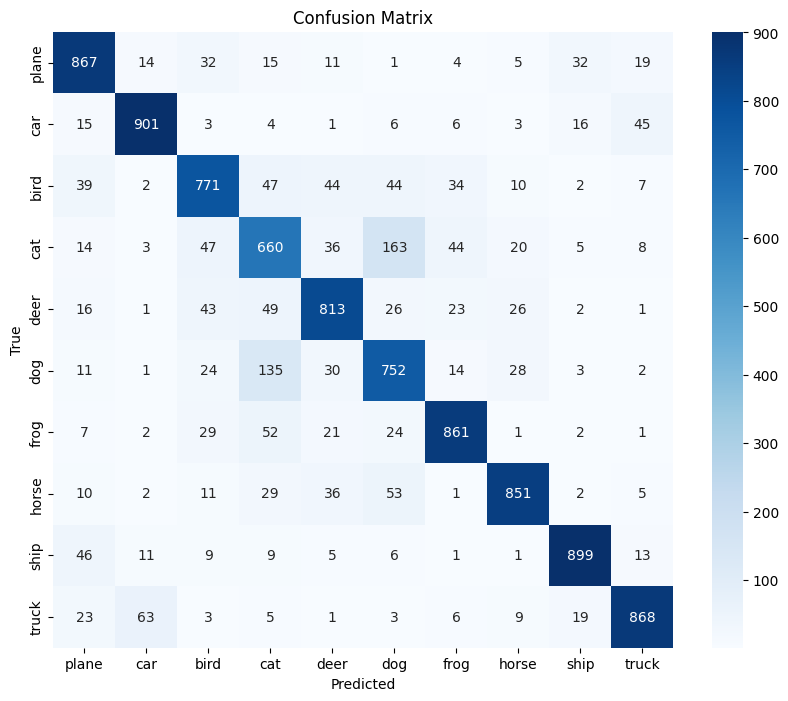

In [8]:
evaluate(model, plot=True)

In [9]:
epochs = 50
for epoch in range(epochs):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
#         print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if (epoch+1)%(epochs//10) == 0:
        print(f'Loss [{epoch}](epoch): ', running_loss / len(trainloader))
        running_loss = 0.0
        evaluate(model)
        cur_id = (epoch+1)//(epochs//10)
        torch.save(model.state_dict(), f"resnet50_cifar10_{cur_id}.pt")

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

Loss [4](epoch):  0.2009112227450856
Accuracy:  0.8234
F1 score:  0.8230504800719286
Loss [9](epoch):  0.19461274688201183
Accuracy:  0.8249
F1 score:  0.8252168276720664
Loss [14](epoch):  0.18568651425792737
Accuracy:  0.829
F1 score:  0.8290204431305318
Loss [19](epoch):  0.1832252956945878
Accuracy:  0.8246
F1 score:  0.8244414212790607
Loss [24](epoch):  0.16756819032342232
Accuracy:  0.8262
F1 score:  0.8264294791679981
Loss [29](epoch):  0.16589944692485778
Accuracy:  0.8289
F1 score:  0.8287365729411134
Loss [34](epoch):  0.15450096498136326
Accuracy:  0.8263
F1 score:  0.8260339166924904
Loss [39](epoch):  0.1502955702831373
Accuracy:  0.8246
F1 score:  0.8236420541356069
Loss [44](epoch):  0.14796947653564957
Accuracy:  0.8279
F1 score:  0.8281078919347478
Loss [49](epoch):  0.1387475984899894
Accuracy:  0.8263
F1 score:  0.8263040331964031


In [10]:
epochs = 50
for epoch in range(epochs):
    losses = []
    running_loss = 0
    for i, inp in enumerate(trainloader):
        inputs, labels = inp
#         print(inputs.shape)
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
    
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    if (epoch+1)%(epochs//10) == 0:
        print(f'Loss [{epoch}](epoch): ', running_loss / len(trainloader))
        running_loss = 0.0
        evaluate(model)
        cur_id = (epoch+1)//(epochs//10)
        torch.save(model.state_dict(), f"resnet50_cifar10_{cur_id}.pt")

    avg_loss = sum(losses)/len(losses)
    scheduler.step(avg_loss)

Loss [4](epoch):  0.1312308750684609
Accuracy:  0.8224
F1 score:  0.8220694531341751
Loss [9](epoch):  0.12706895091611406
Accuracy:  0.8228
F1 score:  0.8222836583130547
Loss [14](epoch):  0.12231366279180092
Accuracy:  0.8232
F1 score:  0.823373734500428
Loss [19](epoch):  0.1148498450236781
Accuracy:  0.8251
F1 score:  0.8249154639573975
Loss [24](epoch):  0.11307353614484106
Accuracy:  0.8243
F1 score:  0.8242860104059115
Loss [29](epoch):  0.10771020284622831
Accuracy:  0.8287
F1 score:  0.8292672472580197
Loss [34](epoch):  0.10120359368984351
Accuracy:  0.8215
F1 score:  0.8220782379323592
Loss [39](epoch):  0.10029121909214331
Accuracy:  0.8265
F1 score:  0.8264814232566773
Loss [44](epoch):  0.09423687196124697
Accuracy:  0.8209
F1 score:  0.8221133505179081
Loss [49](epoch):  0.09158969823928441
Accuracy:  0.8263
F1 score:  0.8260504567296107


Accuracy:  0.8263
F1 score:  0.8260504567296107


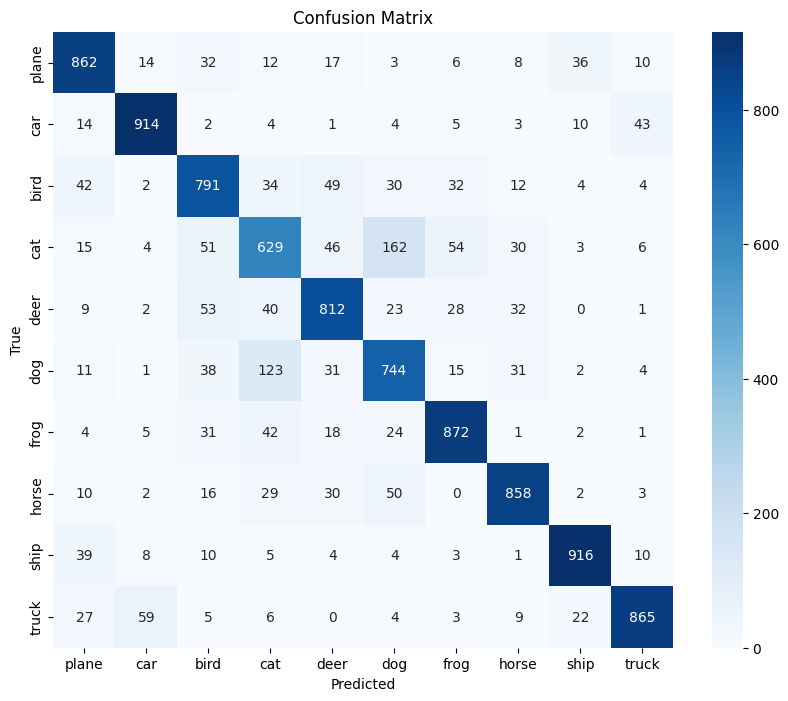

In [11]:
evaluate(model, plot=True)